# Comparación Equitativa de Agentes en Foraging con Hiperparámetros Variados

Este cuaderno lleva a cabo una comparación completa entre distintos tipos de agentes en el juego Foraging, garantizando una evaluación equitativa mediante:

1. **Entrenamiento uniforme**: todos los agentes entrenan con la misma cantidad de episodios.
2. **Variedad de configuraciones**: cada tipo de agente se prueba con diferentes hiperparámetros.
3. **Evaluación exhaustiva**: cada agente se enfrenta a todos los demás.
4. **Análisis detallado**: visualizamos los resultados para identificar qué algoritmos y configuraciones funcionan mejor.

## Hiperparámetros a evaluar para cada tipo de agente

### Fictitious Play (FP)
- **FP_default**: configuración estándar sin sesgos iniciales.
- **FP_biased**: configuración con sesgo inicial hacia ciertas acciones (si aplica a Foraging).

### Regret Matching (RM)
- **RM_default**: política inicial uniforme.
- **RM_biased**: política inicial sesgada (si aplica a Foraging).

### Q-Learning Independiente (IQL)
- **IQL_default**: α=0.1, ε=0.1 (exploración equilibrada).
- **IQL_explore**: α=0.2, ε=0.3 (mayor exploración).
- **IQL_exploit**: α=0.05, ε=0.05 (mayor explotación).

### Joint-Action Learning con Modelado de Agente (JAL-AM)
- **JALAM_default**: α=0.1, ε=0.1 (configuración balanceada).
- **JALAM_explore**: α=0.2, ε=0.3 (mayor exploración).
- **JALAM_exploit**: α=0.05, ε=0.05 (mayor explotación).

# Comparación de Agentes en Foraging

Este cuaderno compara el desempeño de distintos agentes en el juego Foraging, evaluando diferentes hiperparámetros para conseguir una comparación justa.
Los agentes son:
- Fictitious Play (FP)
- Regret Matching (RM)
- Q-Learning Independiente (IQL)
- Joint-Action Learning con Modelado de Agente (JAL-AM)
- Agente Aleatorio (como línea base)

Vamos a entrenar los agentes de manera justa con diferentes hiperparámetros y luego ejecutar una serie de enfrentamientos entre distintas parejas de agentes.

## 1. Importaciones y configuración del entorno

Importamos las librerías necesarias y preparamos el entorno para el juego.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys


if module_path not in sys.path:
    sys.path.append(module_path)

from games.foraging import Foraging 
from agents.fictitiousplay_t import FictitiousPlay
from agents.regretmatching_t import RegretMatching
from agents.iql_agent import IQLAgent, IQLAgentConfig
from agents.jal_am_agent import JointActionLearningAgentModellingAgent
from agents.random_agent import RandomAgent
from base.game import SimultaneousGame, AgentID, ActionDict

NameError: name 'module_path' is not defined

## 2. Carga del entorno de juego Foraging

In [ ]:
FIELD_SIZE = (5, 5)
NUM_PLAYERS = 2
# Con 1 no daba asi que lo hice 3
NUM_FOOD_SITES = 3
MAX_STEPS = 100

config_string = f"Foraging-{FIELD_SIZE[0]}x{FIELD_SIZE[1]}-{NUM_PLAYERS}p-{NUM_FOOD_SITES}f-v3"

game = Foraging(config=config_string, seed=123)
print("Foraging game loaded.")
print("Agents:", game.agents)
print("Action spaces:", game.action_spaces)

Foraging game loaded.
Agents: ['agent_0', 'agent_1']
Action spaces: {'agent_0': Discrete(6), 'agent_1': Discrete(6)}


## 3. Funciones auxiliares para cargar agentes entrenados

Definimos funciones que recuperan el estado guardado de los agentes entrenados en archivos `.pkl`.
(Estas funciones son genéricas y deberían funcionar, pero las rutas de los archivos deben ajustarse para Foraging)

In [ ]:
def load_fp_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int):
    agent = FictitiousPlay(game=game_instance, agent=agent_id)
    counts_path = os.path.join('fp_trainings', game_name, f'agent_{agent_idx}_fp_counts.pkl')
    if os.path.exists(counts_path):
        with open(counts_path, 'rb') as f:
            loaded_counts = pickle.load(f)
            agent.count = loaded_counts
            for ag, ct_array in agent.count.items():
                sum_counts = np.sum(ct_array)
                if sum_counts == 0:
                    agent.learned_policy[ag] = np.ones(game_instance.action_spaces[ag].n) / game_instance.action_spaces[ag].n
                else:
                    agent.learned_policy[ag] = ct_array / sum_counts
        print(f"Loaded Fictitious Play agent {agent_id} for {game_name} from {counts_path}")
    else:
        print(f"Warning: No saved counts found for FP agent {agent_id} at {counts_path}. Using fresh agent.")
    return agent

def load_rm_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int):
    agent = RegretMatching(game=game_instance, agent=agent_id)
    policy_path = os.path.join('rm_trainings', game_name, f'agent_{agent_idx}_rm_policy.pkl')
    if os.path.exists(policy_path):
        with open(policy_path, 'rb') as f:
            agent.learned_policy = pickle.load(f)
        print(f"Loaded Regret Matching agent {agent_id} for {game_name} from {policy_path}")
    else:
        print(f"Warning: No saved policy found for RM agent {agent_id} at {policy_path}. Using fresh agent.")
    return agent

def load_iql_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int, config: IQLAgentConfig = None):
    if config is None:
        config = IQLAgentConfig(epsilon=0.0)
    agent = IQLAgent(game=game_instance, agent=agent_id, config=config)
    q_table_path = os.path.join('iql_trainings', game_name, f'agent_{agent_idx}_q_table.pkl')
    print(f"Attempting to load Q-table from: {q_table_path}")
    if os.path.exists(q_table_path):
        with open(q_table_path, 'rb') as f:
            agent.Q = pickle.load(f)
        print(f"Loaded IQL agent {agent_id} for {game_name} from {q_table_path}")
        if agent.Q:
            print(f"  Q-table loaded. Number of states: {len(agent.Q)}")
            sample_state = next(iter(agent.Q)) if agent.Q else None
            if sample_state:
                print(f"  Sample Q-values for state '{sample_state}': {agent.Q[sample_state]}")
            if not any(any(v != 0 for v in q_vals) for q_vals in agent.Q.values()):
                 print("  WARNING: All Q-values in the loaded table are zero.")
        else:
            print("  WARNING: Q-table is empty after loading.")
    else:
        print(f"Warning: No saved Q-table found for IQL agent {agent_id} at {q_table_path}. Using fresh agent.")
        print(f"  Fresh IQL agent Q-table state: {len(agent.Q)} states.")
    agent.epsilon = 0
    return agent

def load_jalam_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int):
    agent = JointActionLearningAgentModellingAgent(game=game_instance, agent=agent_id, epsilon=0.0)
    data_path = os.path.join('jalam_trainings', game_name, f'agent_{agent_idx}_jalam_model.pkl')

    if os.path.exists(data_path):
        with open(data_path, 'rb') as f:
            saved_data = pickle.load(f)
            if 'Q_table' in saved_data and hasattr(agent, 'Q'):
                agent.Q = saved_data['Q_table']
            if 'model_counts' in saved_data and hasattr(agent, 'model_counts'):
                agent.model_counts = saved_data['model_counts']
            if 'Q' in saved_data and hasattr(agent, 'Q'):
                agent.Q = saved_data['Q']
            if 'opp_count' in saved_data and hasattr(agent, 'opp_count'):
                agent.opp_count = saved_data['opp_count']
            if 'joint_count' in saved_data and hasattr(agent, 'joint_count'):
                agent.joint_count = saved_data['joint_count']
        print(f"Loaded JAL-AM agent {agent_id} for {game_name} from {data_path}")
    else:
        print(f"Warning: No saved model found for JAL-AM agent {agent_id} at {data_path}. Using fresh agent.")
    agent.epsilon = 0
    return agent

## 4. Cargar agentes entrenados para Foraging

Instanciar agentes. Para los agentes entrenados, cargamos su estado guardado.
El juego es Foraging y los agentes son “agent_0” y “agent_1”.
**MODIFICADO**: `GAME_NAME` a "Foraging_5x5_2p_1f" o el nombre de carpeta correspondiente.

In [ ]:
GAME_NAME = "Foraging_5x5_2p_3f"
agent_ids = game.agents


fp_configs = [
    {"name": "FP_default", "params": {"initial": None, "seed": 123}},
  
]


rm_configs = [
    {"name": "RM_default", "params": {"initial": None, "seed": 123}},
 
]

iql_configs = [
    {"name": "IQL_default", "params": {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1, "min_epsilon": 0.01, "epsilon_decay": 0.995, "seed": 123, "use_reward_shaping": True}},
    {"name": "IQL_explore", "params": {"alpha": 0.2, "gamma": 0.99, "epsilon": 0.3, "min_epsilon": 0.05, "epsilon_decay": 0.99, "seed": 123, "use_reward_shaping": True}},
    {"name": "IQL_exploit", "params": {"alpha": 0.05, "gamma": 0.99, "epsilon": 0.05, "min_epsilon": 0.01, "epsilon_decay": 0.999, "seed": 123, "use_reward_shaping": True}}
]

jalam_configs = [
    {"name": "JALAM_default", "params": {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1, "min_epsilon": 0.01, "epsilon_decay": 0.995, "seed": 123}},
    {"name": "JALAM_explore", "params": {"alpha": 0.2, "gamma": 0.99, "epsilon": 0.3, "min_epsilon": 0.05, "epsilon_decay": 0.99}},
    {"name": "JALAM_exploit", "params": {"alpha": 0.05, "gamma": 0.99, "epsilon": 0.05, "min_epsilon": 0.01, "epsilon_decay": 0.999, "seed": 123}}
]

def create_fp_agent(game_instance, agent_id, config):
    return FictitiousPlay(game=game_instance, agent=agent_id, **config["params"])

def create_rm_agent(game_instance, agent_id, config):
    return RegretMatching(game=game_instance, agent=agent_id, **config["params"])

def create_iql_agent(game_instance, agent_id, config):
    iql_config_obj = IQLAgentConfig(**config["params"])
    return IQLAgent(game=game_instance, agent=agent_id, config=iql_config_obj)

def create_jalam_agent(game_instance, agent_id, config):
    return JointActionLearningAgentModellingAgent(game=game_instance, agent=agent_id, **config["params"])

agents_pool = {}

random_agent_0 = RandomAgent(game, agent_ids[0])
random_agent_1 = RandomAgent(game, agent_ids[1])
agents_pool["Random"] = random_agent_0

print("Creating agent instances with different hyperparameters for Foraging...")

for config in fp_configs:
    agent = load_fp_agent(game, agent_ids[0], GAME_NAME, 0)
    if "initial" in config["params"]: agent.initial = config["params"]["initial"]
    agents_pool[config["name"]] = agent
    print(f"Loaded/Created {config['name']} agent for player 0")

for config in rm_configs:
    agent = load_rm_agent(game, agent_ids[0], GAME_NAME, 0)
    agents_pool[config["name"]] = agent
    print(f"Loaded/Created {config['name']} agent for player 0")

for config_dict in iql_configs:
    agent = load_iql_agent(game, agent_ids[0], GAME_NAME, 0, IQLAgentConfig(**config_dict["params"]))
    agents_pool[config_dict["name"]] = agent
    print(f"Loaded/Created {config_dict['name']} agent for player 0")

for config in jalam_configs:
    agent = load_jalam_agent(game, agent_ids[0], GAME_NAME, 0)
    agents_pool[config["name"]] = agent
    print(f"Loaded/Created {config['name']} agent for player 0")

print("\nAvailable agents for comparison:", list(agents_pool.keys()))

Creating agent instances with different hyperparameters for Foraging...
Loaded Fictitious Play agent agent_0 for Foraging_5x5_2p_3f from fp_trainings/Foraging_5x5_2p_3f/agent_0_fp_counts.pkl
Loaded/Created FP_default agent for player 0
Loaded Regret Matching agent agent_0 for Foraging_5x5_2p_3f from rm_trainings/Foraging_5x5_2p_3f/agent_0_rm_policy.pkl
Loaded/Created RM_default agent for player 0
Attempting to load Q-table from: iql_trainings/Foraging_5x5_2p_3f/agent_0_q_table.pkl
Loaded IQL agent agent_0 for Foraging_5x5_2p_3f from iql_trainings/Foraging_5x5_2p_3f/agent_0_q_table.pkl
  Q-table loaded. Number of states: 20
  Sample Q-values for state '(np.float32(1.0), np.float32(2.0), np.float32(2.0), np.float32(3.0), np.float32(3.0), np.float32(2.0), np.float32(-1.0), np.float32(-1.0), np.float32(0.0), np.float32(3.0))': [0.06773653 0.16897584 0.04886456 0.07812864 0.04985657 0.04797306]
Loaded/Created IQL_default agent for player 0
Attempting to load Q-table from: iql_trainings/Fora

## 5. Función de simulación

Esta función ejecuta un enfrentamiento entre dos agentes durante una cantidad determinada de episodios.
**MODIFICADO**: La simulación para Foraging implica múltiples pasos por episodio.

In [ ]:
def run_match_foraging(game_instance, agent1, agent2, num_episodes):
    total_reward_agent1 = 0
    total_reward_agent2 = 0
    history_rewards_agent1 = []
    history_rewards_agent2 = []

    agent_ids = game_instance.possible_agents
    agent1_id = agent_ids[0]
    agent2_id = agent_ids[1]

    if hasattr(agent1, 'game'):
        agent1.game = game_instance
    if hasattr(agent2, 'game'):
        agent2.game = game_instance

    for episode in range(num_episodes):
        game_instance.reset()
        observations = game_instance.observations
        infos = game_instance.infos

        terminated = {agent_id: False for agent_id in agent_ids}
        truncated = {agent_id: False for agent_id in agent_ids}
        
        if hasattr(agent1, 'reset'):
            try:
                agent1.reset(observations[agent1_id])
            except TypeError:
                try:
                    agent1.reset()
                except Exception as e:
                    print(f"Error resetting agent1: {e}")
        
        if hasattr(agent2, 'reset'):
            try:
                agent2.reset(observations[agent2_id])
            except TypeError:
                try:
                    agent2.reset()
                except Exception as e:
                    print(f"Error resetting agent2: {e}")


        current_episode_reward_agent1 = 0
        current_episode_reward_agent2 = 0
        current_step = 0
        
        while not (all(terminated.values()) or all(truncated.values())) and current_step < MAX_STEPS:
            action1_val = agent1.action()
            action2_val = agent2.action()
            
            actions = {agent1_id: action1_val, agent2_id: action2_val}

            next_observations, rewards, terminated_update, truncated_update, infos_update = game_instance.step(actions)

            terminated.update(terminated_update)
            truncated.update(truncated_update)
            
            current_episode_reward_agent1 += rewards[agent1_id]
            current_episode_reward_agent2 += rewards[agent2_id]
            
            observations = next_observations

            current_step += 1

        total_reward_agent1 += current_episode_reward_agent1
        total_reward_agent2 += current_episode_reward_agent2
        history_rewards_agent1.append(current_episode_reward_agent1)
        history_rewards_agent2.append(current_episode_reward_agent2)

    avg_reward_agent1 = total_reward_agent1 / num_episodes if num_episodes > 0 else 0
    avg_reward_agent2 = total_reward_agent2 / num_episodes if num_episodes > 0 else 0

    return {
        "avg_reward_agent1": avg_reward_agent1,
        "avg_reward_agent2": avg_reward_agent2,
        "total_reward_agent1": total_reward_agent1,
        "total_reward_agent2": total_reward_agent2,
        "history_agent1": history_rewards_agent1,
        "history_agent2": history_rewards_agent2
    }

## 6. Definir parejas y ejecutar experimentos

Configuramos las parejas de agentes que se enfrentarán y ejecutamos los experimentos.

In [ ]:
def get_agent_instance_foraging(agent_type_str, game_instance, agent_id_in_game, game_name_for_load, agent_idx_for_load, config_params=None):
    if agent_type_str == "Random":
        return RandomAgent(game_instance, agent_id_in_game)
    
    if agent_type_str == "FP":
        try:
            agent = load_fp_agent(game_instance, agent_id_in_game, game_name_for_load, agent_idx_for_load)
        except Exception as e:
            print(f"Failed to load FP agent, creating new. Error: {e}")
            base_config = {"initial": None, "seed": 123}
            if config_params: base_config.update(config_params)
            agent = FictitiousPlay(game=game_instance, agent=agent_id_in_game, **base_config)
        return agent
    
    elif agent_type_str == "RM":
        try:
            agent = load_rm_agent(game_instance, agent_id_in_game, game_name_for_load, agent_idx_for_load)
        except Exception as e:
            print(f"Failed to load RM agent, creating new. Error: {e}")
            base_config = {"initial": None, "seed": 123}
            if config_params: base_config.update(config_params)
            agent = RegretMatching(game=game_instance, agent=agent_id_in_game, **base_config)
        return agent
    
    elif agent_type_str == "IQL":
        default_iql_params = {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1, "min_epsilon": 0.01, "epsilon_decay": 0.995, "seed": 123, "use_reward_shaping": True}
        if config_params: default_iql_params.update(config_params)
        iql_config_obj = IQLAgentConfig(**default_iql_params)
        
        try:
            agent = load_iql_agent(game_instance, agent_id_in_game, game_name_for_load, agent_idx_for_load, config=iql_config_obj) 
        except Exception as e:
            print(f"Failed to load IQL agent, creating new. Error: {e}")
            agent = IQLAgent(game=game_instance, agent=agent_id_in_game, config=iql_config_obj)
            agent.epsilon = 0 # Asegurar modo evaluación
        return agent
    
    elif agent_type_str == "JALAM":
        base_jalam_params = {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1, "min_epsilon": 0.01, "epsilon_decay": 0.995, "seed": 123}
        if config_params: base_jalam_params.update(config_params)
        try:
            agent = load_jalam_agent(game_instance, agent_id_in_game, game_name_for_load, agent_idx_for_load)
        except Exception as e:
            print(f"Failed to load JALAM agent, creating new. Error: {e}")
            agent = JointActionLearningAgentModellingAgent(game=game_instance, agent=agent_id_in_game, **base_jalam_params)
            agent.epsilon = 0 # Asegurar modo evaluación
        return agent
    
    else:
        raise ValueError(f"Unknown agent type: {agent_type_str}")

agent_creation_info = {}
for name in agents_pool: # agents_pool ya contiene instancias (potencialmente cargadas)
    if name == "Random":
        agent_creation_info[name] = {"type": "Random", "config_params": None}
    elif name.startswith("FP_"):
        original_config = next(c for c in fp_configs if c["name"] == name)
        agent_creation_info[name] = {"type": "FP", "config_params": original_config["params"]}
    elif name.startswith("RM_"):
        original_config = next(c for c in rm_configs if c["name"] == name)
        agent_creation_info[name] = {"type": "RM", "config_params": original_config["params"]}
    elif name.startswith("IQL_"):
        original_config = next(c for c in iql_configs if c["name"] == name)
        agent_creation_info[name] = {"type": "IQL", "config_params": original_config["params"]}
    elif name.startswith("JALAM_"):
        original_config = next(c for c in jalam_configs if c["name"] == name)
        agent_creation_info[name] = {"type": "JALAM", "config_params": original_config["params"]}

print("\nAgent creation info prepared for Foraging matches.")


Agent creation info prepared for Foraging matches.


In [ ]:
EVAL_EPISODES = 200

evaluation_pairs = []
agent_names_list = list(agents_pool.keys())
for i in range(len(agent_names_list)):
    for j in range(len(agent_names_list)):
        evaluation_pairs.append((agent_names_list[i], agent_names_list[j]))

print(f"Will run {len(evaluation_pairs)} evaluation matches with {EVAL_EPISODES} episodes each for Foraging.")

results_foraging = {}

for agent1_name, agent2_name in evaluation_pairs:
    match_key = f"{agent1_name}_vs_{agent2_name}"
    print(f"\nEvaluating Foraging match: {match_key}")
    
    eval_game = Foraging(config=config_string, seed=123)
    
    agent1_info = agent_creation_info[agent1_name]
    agent2_info = agent_creation_info[agent2_name]
    
    agent1 = get_agent_instance_foraging(
        agent1_info["type"], eval_game, eval_game.agents[0], 
        GAME_NAME,
        0,
        agent1_info["config_params"]
    )
    
    agent2 = get_agent_instance_foraging(
        agent2_info["type"], eval_game, eval_game.agents[1], 
        GAME_NAME,
        1,
        agent2_info["config_params"]
    )
        
    if hasattr(agent1, "epsilon"): agent1.epsilon = 0
    if hasattr(agent1, "learn"): agent1.learn = False
    if hasattr(agent2, "epsilon"): agent2.epsilon = 0
    if hasattr(agent2, "learn"): agent2.learn = False

    match_results = run_match_foraging(eval_game, agent1, agent2, EVAL_EPISODES)
    results_foraging[match_key] = match_results
    
    print(f"  Results: {agent1_name} avg reward: {match_results['avg_reward_agent1']:.3f}, "
          f"{agent2_name} avg reward: {match_results['avg_reward_agent2']:.3f}")

print("\nAll Foraging evaluation matches completed.")

Will run 81 evaluation matches with 200 episodes each for Foraging.

Evaluating Foraging match: Random_vs_Random


/opt/homebrew/Caskroom/miniconda/base/envs/py311/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:245: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


  Results: Random avg reward: 0.010, Random avg reward: 0.010

Evaluating Foraging match: Random_vs_FP_default
Loaded Fictitious Play agent agent_1 for Foraging_5x5_2p_3f from fp_trainings/Foraging_5x5_2p_3f/agent_1_fp_counts.pkl
  Results: Random avg reward: 0.018, FP_default avg reward: 0.018

Evaluating Foraging match: Random_vs_RM_default
Loaded Regret Matching agent agent_1 for Foraging_5x5_2p_3f from rm_trainings/Foraging_5x5_2p_3f/agent_1_rm_policy.pkl
  Results: Random avg reward: 0.013, RM_default avg reward: 0.013

Evaluating Foraging match: Random_vs_IQL_default
Attempting to load Q-table from: iql_trainings/Foraging_5x5_2p_3f/agent_1_q_table.pkl
Loaded IQL agent agent_1 for Foraging_5x5_2p_3f from iql_trainings/Foraging_5x5_2p_3f/agent_1_q_table.pkl
  Q-table loaded. Number of states: 20
  Sample Q-values for state '(np.float32(1.0), np.float32(2.0), np.float32(2.0), np.float32(3.0), np.float32(3.0), np.float32(2.0), np.float32(-1.0), np.float32(-1.0), np.float32(0.0), np.f

In [ ]:
EVAL_EPISODES = 200

evaluation_pairs = []
agent_names_list = list(agents_pool.keys())
for i in range(len(agent_names_list)):
    for j in range(len(agent_names_list)):
        evaluation_pairs.append((agent_names_list[i], agent_names_list[j]))

print(f"Will run {len(evaluation_pairs)} evaluation matches with {EVAL_EPISODES} episodes each for Foraging.")

results_foraging = {}

for agent1_name, agent2_name in evaluation_pairs:
    match_key = f"{agent1_name}_vs_{agent2_name}"
    print(f"\nEvaluating Foraging match: {match_key}")
    
    eval_game = Foraging(config=config_string, seed=123)
    
    agent1_info = agent_creation_info[agent1_name]
    agent2_info = agent_creation_info[agent2_name]
    

    agent1 = get_agent_instance_foraging(
        agent1_info["type"], eval_game, eval_game.agents[0], 
        GAME_NAME,
        0,
        agent1_info["config_params"]
    )
    
    agent2 = get_agent_instance_foraging(
        agent2_info["type"], eval_game, eval_game.agents[1], 
        GAME_NAME,
        1,
        agent2_info["config_params"]
    )
        
    if hasattr(agent1, "epsilon"): agent1.epsilon = 0
    if hasattr(agent1, "learn"): agent1.learn = False
    if hasattr(agent2, "epsilon"): agent2.epsilon = 0
    if hasattr(agent2, "learn"): agent2.learn = False

    match_results = run_match_foraging(eval_game, agent1, agent2, EVAL_EPISODES)
    results_foraging[match_key] = match_results
    
    print(f"  Results: {agent1_name} avg reward: {match_results['avg_reward_agent1']:.3f}, "
          f"{agent2_name} avg reward: {match_results['avg_reward_agent2']:.3f}")

print("\nAll Foraging evaluation matches completed.")

Will run 81 evaluation matches with 200 episodes each for Foraging.

Evaluating Foraging match: Random_vs_Random
  Results: Random avg reward: 0.022, Random avg reward: 0.022

Evaluating Foraging match: Random_vs_FP_default
Loaded Fictitious Play agent agent_1 for Foraging_5x5_2p_3f from fp_trainings/Foraging_5x5_2p_3f/agent_1_fp_counts.pkl
  Results: Random avg reward: 0.024, FP_default avg reward: 0.024

Evaluating Foraging match: Random_vs_RM_default
Loaded Regret Matching agent agent_1 for Foraging_5x5_2p_3f from rm_trainings/Foraging_5x5_2p_3f/agent_1_rm_policy.pkl
  Results: Random avg reward: 0.010, RM_default avg reward: 0.010

Evaluating Foraging match: Random_vs_IQL_default
Attempting to load Q-table from: iql_trainings/Foraging_5x5_2p_3f/agent_1_q_table.pkl
Loaded IQL agent agent_1 for Foraging_5x5_2p_3f from iql_trainings/Foraging_5x5_2p_3f/agent_1_q_table.pkl
  Q-table loaded. Number of states: 20
  Sample Q-values for state '(np.float32(1.0), np.float32(2.0), np.float32(2

## 7. Analizar y visualizar resultados detallados para Foraging

En esta sección analizamos los resultados de todas las configuraciones de agentes y sus enfrentamientos en Foraging.
Las métricas de "win/loss/tie" pueden no ser tan directas como en RPS, ya que Foraging es sobre acumulación de recompensas.
Nos centraremos en las recompensas promedio.


=== Summary of Average Rewards (Foraging) ===

Random_vs_Random: Random got 0.013, Random got 0.013
Random_vs_FP_default: Random got 0.007, FP_default got 0.007
Random_vs_RM_default: Random got 0.015, RM_default got 0.015
Random_vs_IQL_default: Random got 0.125, IQL_default got 0.125
Random_vs_IQL_explore: Random got 0.125, IQL_explore got 0.125
Random_vs_IQL_exploit: Random got 0.125, IQL_exploit got 0.125
Random_vs_JALAM_default: Random got 0.000, JALAM_default got 0.000
Random_vs_JALAM_explore: Random got 0.000, JALAM_explore got 0.000
Random_vs_JALAM_exploit: Random got 0.000, JALAM_exploit got 0.000
FP_default_vs_Random: FP_default got 0.007, Random got 0.007
FP_default_vs_FP_default: FP_default got 0.007, FP_default got 0.007
FP_default_vs_RM_default: FP_default got 0.005, RM_default got 0.005
FP_default_vs_IQL_default: FP_default got 0.099, IQL_default got 0.099
FP_default_vs_IQL_explore: FP_default got 0.099, IQL_explore got 0.099
FP_default_vs_IQL_exploit: FP_default got 0.09

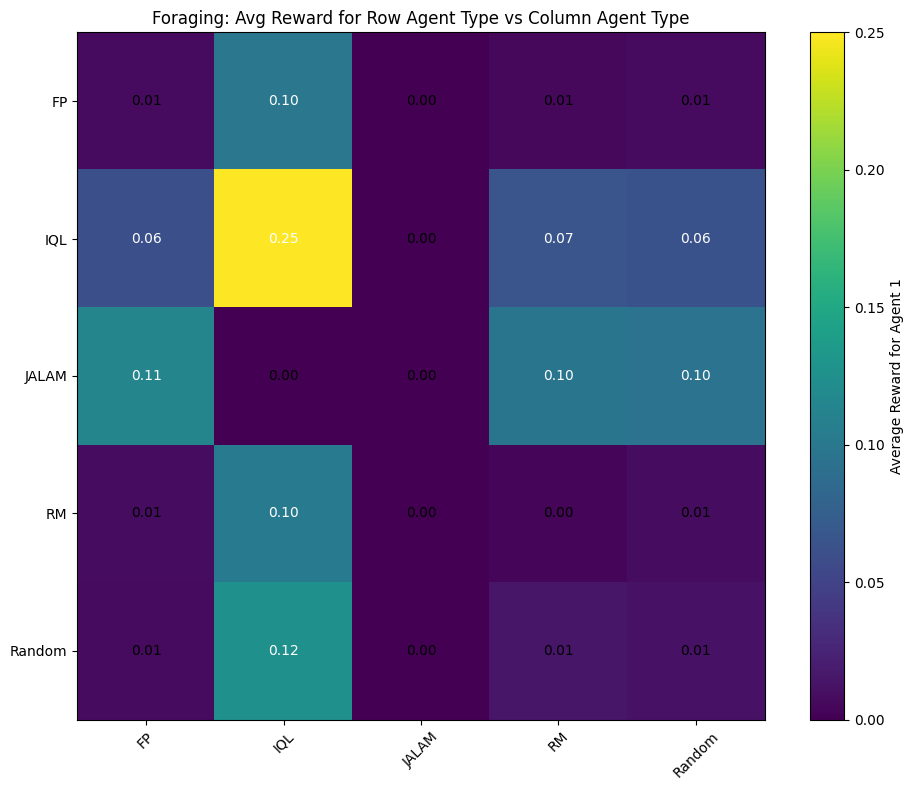

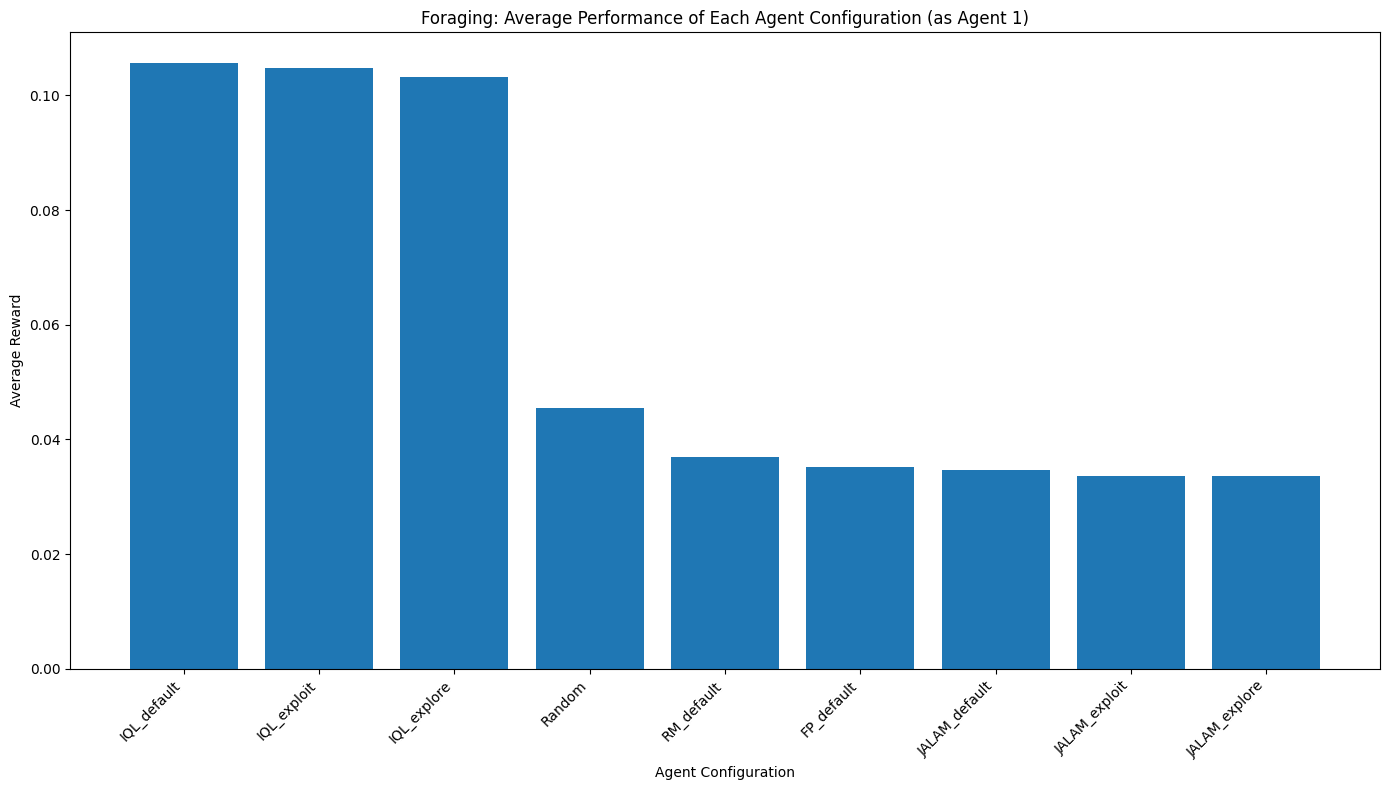

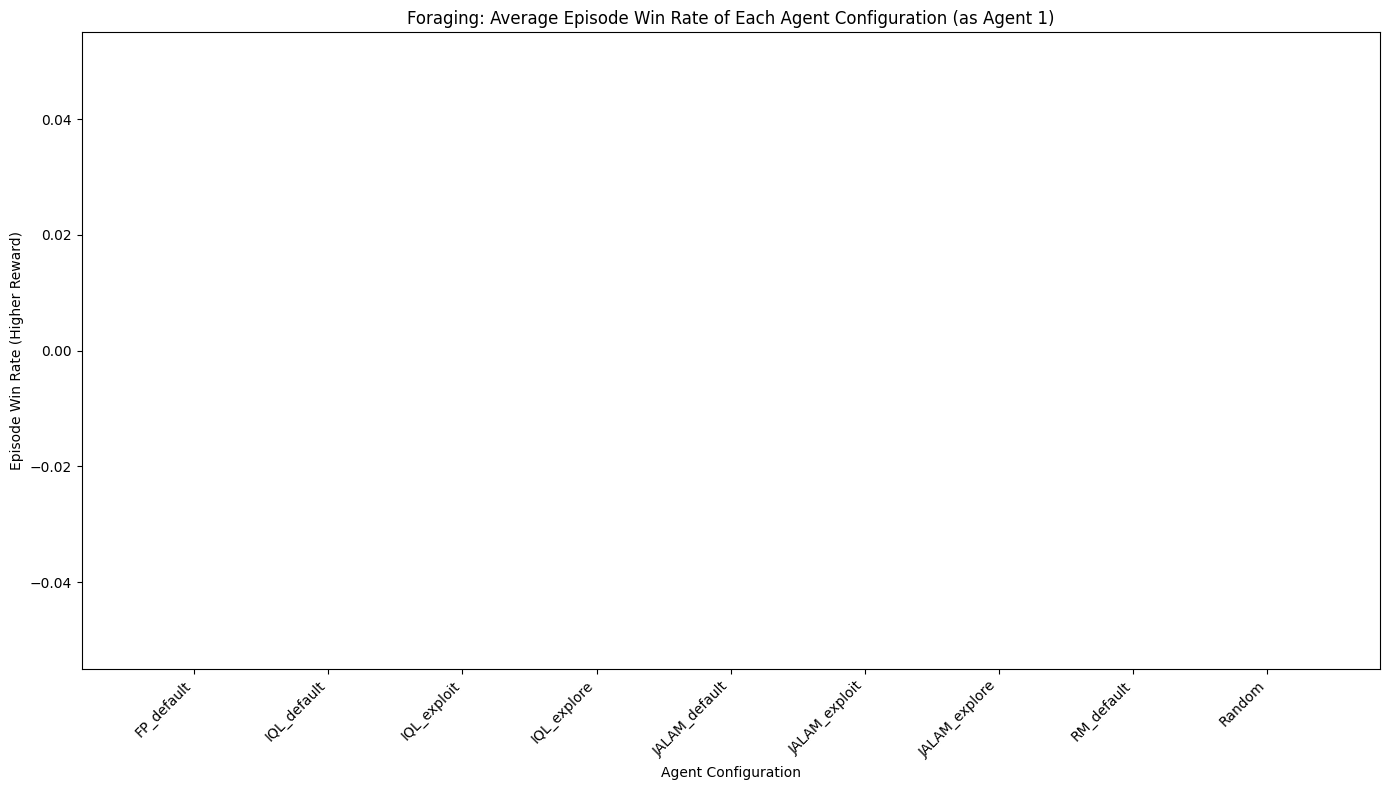


Foraging analysis complete. Charts show performance based on rewards.


In [ ]:
import pandas as pd
try:
    import seaborn as sns
    has_seaborn = True
except ImportError:
    has_seaborn = False

results_data_foraging = []
for match_key, res in results_foraging.items():
    agent1_name, agent2_name = match_key.split('_vs_')
    
    hist1 = np.array(res['history_agent1'])
    hist2 = np.array(res['history_agent2'])
    
    wins1 = np.sum(hist1 > hist2)
    wins2 = np.sum(hist2 > hist1)
    ties = np.sum(hist1 == hist2)
    total_episodes = len(hist1)

    results_data_foraging.append({
        'match': match_key,
        'agent1': agent1_name,
        'agent2': agent2_name,
        'agent1_avg_reward': res['avg_reward_agent1'],
        'agent2_avg_reward': res['avg_reward_agent2'],
        'agent1_win_rate': wins1 / total_episodes if total_episodes > 0 else 0,
        'agent2_win_rate': wins2 / total_episodes if total_episodes > 0 else 0,
        'tie_rate': ties / total_episodes if total_episodes > 0 else 0,
        'agent1_type': agent_creation_info[agent1_name]["type"],
        'agent2_type': agent_creation_info[agent2_name]["type"],
    })

df_results_foraging = pd.DataFrame(results_data_foraging)

print("\n=== Summary of Average Rewards (Foraging) ===\n")
for _, row in df_results_foraging.iterrows():
    print(f"{row['match']}: {row['agent1']} got {row['agent1_avg_reward']:.3f}, {row['agent2']} got {row['agent2_avg_reward']:.3f}")

print("\n=== Win/Tie/Loss Analysis (Foraging - based on episode rewards) ===\n")
for _, row in df_results_foraging.iterrows():
    print(f"Match {row['match']}:")
    print(f"  {row['agent1']} win rate (higher episode reward): {row['agent1_win_rate']:.1%}")
    print(f"  {row['agent2']} win rate (higher episode reward): {row['agent2_win_rate']:.1%}")
    print(f"  Tie rate (equal episode reward): {row['tie_rate']:.1%}")


print("\n=== Creating performance visualizations for Foraging... ===\n")

# Heatmap de recompensas promedio por tipo de agente
# Usamos los tipos base de agente (FP, RM, IQL, JALAM, Random)
agent_base_types = sorted(list(set(df_results_foraging['agent1_type'].unique()) | set(df_results_foraging['agent2_type'].unique())))

pivot_data_foraging_type = []
for type1 in agent_base_types:
    for type2 in agent_base_types:
        rewards_type1_vs_type2 = df_results_foraging[
            (df_results_foraging['agent1_type'] == type1) & 
            (df_results_foraging['agent2_type'] == type2)
        ]['agent1_avg_reward'].mean()

        pivot_data_foraging_type.append({
            'agent1_type': type1,
            'agent2_type': type2,
            'avg_reward_agent1': rewards_type1_vs_type2 if not pd.isna(rewards_type1_vs_type2) else 0
        })

df_pivot_foraging_type = pd.DataFrame(pivot_data_foraging_type)

if not df_pivot_foraging_type.empty:
    heatmap_table_type = df_pivot_foraging_type.pivot(index='agent1_type', columns='agent2_type', values='avg_reward_agent1')
    plt.figure(figsize=(10, 8))
    if has_seaborn:
        sns.heatmap(heatmap_table_type, annot=True, cmap='viridis', fmt='.2f')
    else:
        plt.imshow(heatmap_table_type.fillna(0).values, cmap='viridis')
        plt.colorbar(label='Average Reward for Agent 1')
        for i in range(heatmap_table_type.shape[0]):
            for j in range(heatmap_table_type.shape[1]):
                val = heatmap_table_type.iloc[i, j]
                plt.text(j, i, f'{val:.2f}' if not pd.isna(val) else 'N/A', 
                         ha='center', va='center', color='white' if val > heatmap_table_type.fillna(0).values.mean() else 'black')
        plt.xticks(range(len(heatmap_table_type.columns)), heatmap_table_type.columns, rotation=45)
        plt.yticks(range(len(heatmap_table_type.index)), heatmap_table_type.index)

    plt.title('Foraging: Avg Reward for Row Agent Type vs Column Agent Type')
    plt.tight_layout()
    plt.show()
else:
    print("No data for type-vs-type heatmap for Foraging.")


# Bar chart de rendimiento promedio por configuración de agente
df_summary_foraging = df_results_foraging.groupby('agent1')['agent1_avg_reward'].mean().reset_index()
df_summary_foraging = df_summary_foraging.sort_values('agent1_avg_reward', ascending=False)

plt.figure(figsize=(14, 8))
if has_seaborn:
    sns.barplot(x='agent1', y='agent1_avg_reward', data=df_summary_foraging, palette="viridis")
else:
    plt.bar(df_summary_foraging['agent1'], df_summary_foraging['agent1_avg_reward'])
plt.title('Foraging: Average Performance of Each Agent Configuration (as Agent 1)')
plt.xlabel('Agent Configuration')
plt.ylabel('Average Reward')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nForaging analysis complete. Charts show performance based on rewards.")

## Conclusión General para Foraging

(Esta sección se llenará después de ejecutar el cuaderno y analizar los gráficos)

Consideraciones para Foraging:
- **Complejidad del estado**: El espacio de estados en Foraging es mucho mayor que en RPS. Esto puede afectar más a IQL y JALAM si la representación del estado no es adecuada.
- **Importancia de la exploración**: Encontrar comida en un mapa requiere una buena exploración. Los hiperparámetros de `epsilon` y `epsilon_decay` son cruciales.
- **Reward shaping**: Para IQL, `use_reward_shaping` puede ser muy útil para guiar al agente.
- **Duración de los episodios**: `max_steps` afecta cuánto tiempo tienen los agentes para recolectar comida.
- **FP y RM en Foraging**: Estos agentes no usan explícitamente el estado del juego (posiciones) para tomar decisiones, sino que aprenden políticas basadas en las acciones pasadas de los oponentes. Su desempeño podría ser limitado si el estado es muy relevante. RM podría adaptarse mejor si se calculan los regrets por estado, pero la implementación actual es más simple.

Se espera que los agentes de RL (IQL, JALAM) con buena configuración y representación de estado superen a FP, RM y Random en Foraging, dada la naturaleza del juego que requiere planificación y reacción al entorno.